In [10]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cProfile
import pstats

In [11]:
def natural_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points

def mps_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def natural(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,is_parallel=False)
    points = l.gen_samples(num_ports) 
    return points
def mps(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,is_parallel=False)
    points = l.gen_samples(num_ports) 
    return points
def linear(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,is_parallel=False)
    points = l.gen_samples(num_ports) 
    return points

In [32]:
trials = 3
d_list = [50, 100, 200, 400, 800, 1600]
n = 14
data = {'index':d_list}
frame = pd.DataFrame(data)
frame = frame.set_index('index')
names = set()

#list contiants the function and a string of its name
run_list = [(natural, "natural"),(natural_thread,"natural thread"),(linear, "linear"),(linear_thread,"linear thread"),(mps,"mps"),(mps_thread,"mps thread")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in d_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        times.append(process_time)
        
    frame[method_name] = times        


names = list(names)     
 


In [33]:
comparse= [('natural', 'natural thread'),('mps', 'mps thread'),('linear', 'linear thread')]



def speed_up_cal(data_frame, compare_list, dimension_list):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in dimension_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " speed-up"] = result


speed_up_cal(frame, comparse, d_list)




[1.2694619  1.13261739 1.2586463  1.27392583 1.27891401 1.30188679]


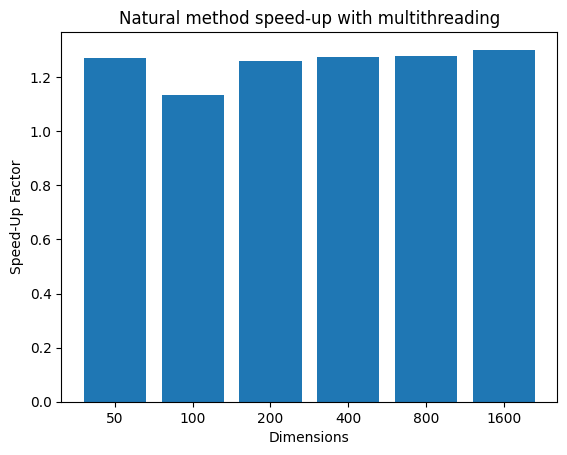

[0.95283488 0.98234196 0.98980295 0.98503883 0.98791993 1.02414512]


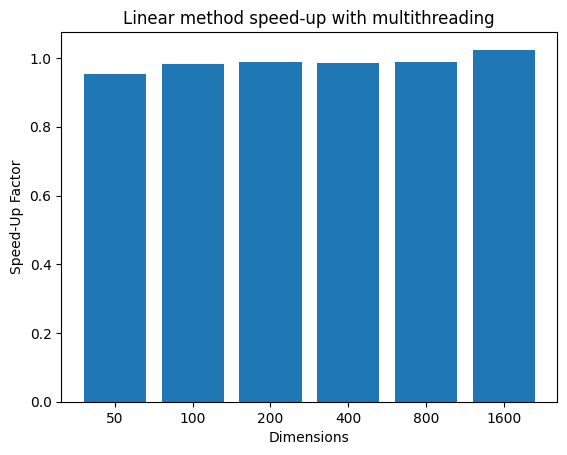

[0.30739777 0.52922428 0.77121283 1.05127776 0.88744519 1.08979061]


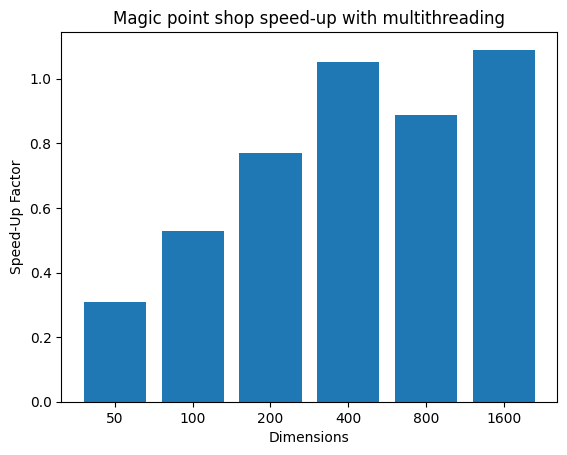

In [34]:
x = lambda array: [str(x) for x in array]

y_axis = frame["natural speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Natural method speed-up with multithreading')
plt.show()

y_axis = frame["linear speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Linear method speed-up with multithreading')
plt.show()

y_axis = frame["mps speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Magic point shop speed-up with multithreading')
plt.show()

In [41]:
p_list = [2 ** x for x in range(5, 15)]
dimension = 1000
records = {'index':p_list}
frame2 = pd.DataFrame(records)
frame2 = frame2.set_index('index')
names = set()

for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in p_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, p)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt

        # print(f'Process time {process_time} method name {method_name}')
        times.append(process_time)
    
    frame2[method_name] = times        


names = list(names)     
speed_up_cal(frame2,comparse, p_list)

[0.79697989 1.36468062 1.07998853 1.09453457 1.12983732 1.1960877
 1.27704255 1.27561383 1.29823177 1.28480074]


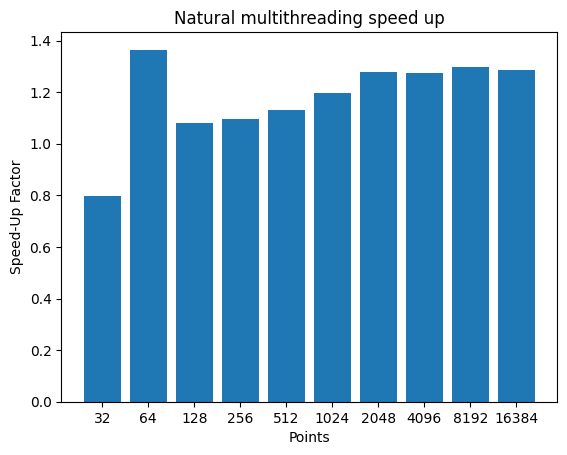

[1.04287007 0.98524201 1.04053195 1.00994811 1.02943059 1.00979342
 1.01374116 1.00220547 1.00478859 0.9601515 ]


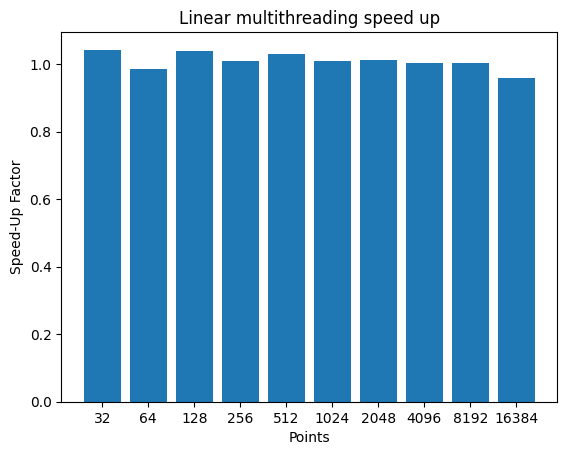

[0.73568183 0.96779917 1.08344065 1.15359867 1.18175492 1.21950956
 1.20933221 1.23600425 1.2228199  1.23942111]


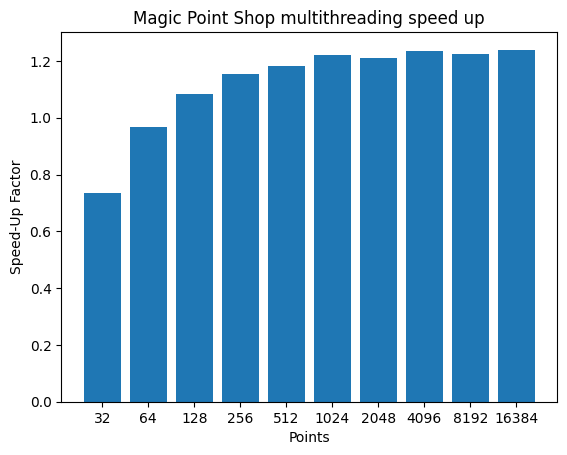

In [42]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["natural speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Natural multithreading speed up')
plt.show()

y_axis = frame2["linear speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Linear multithreading speed up')
plt.show()

y_axis = frame2["mps speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Magic Point Shop multithreading speed up')
plt.show()